In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import datetime as dt

import matplotlib.cm as cm
import matplotlib.colors as col
colors= sns.color_palette()

% matplotlib inline

In [2]:
rain_data = pd.read_csv('929008.csv', parse_dates=['DATE'])

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (1,2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
rain_data.head()

,STATION,ELEVATION,LATITUDE,LONGITUDE,DATE,MDPR,PRCP,SNWD,SNOW,TMAX,TMIN
0,GHCND:USC00458278,7.6,47.25,-122.417,1996-01-01,-9999.0,0.00,-9999.0,0.0,54,46
1,GHCND:USC00458278,7.6,47.25,-122.417,1996-01-02,-9999.0,0.02,-9999.0,0.0,56,47
2,GHCND:USC00458278,7.6,47.25,-122.417,1996-01-03,-9999.0,0.42,-9999.0,0.0,56,46
3,GHCND:USC00458278,7.6,47.25,-122.417,1996-01-04,-9999.0,0.00,-9999.0,0.0,47,40
4,GHCND:USC00458278,7.6,47.25,-122.417,1996-01-05,-9999.0,0.20,-9999.0,0.0,44,38


In [4]:
# Null values were filled with -9999.0 so I'll redefine the values of the dataframe to be
# within the realm of reason.

rain_data = rain_data[rain_data.PRCP > -10]
rain_data = rain_data[rain_data.TMIN > -100]
rain_data = rain_data[rain_data.TMAX > -100]

In [5]:
# I'm only interested in exploring the year 2015

rain_2015 = rain_data[(rain_data.DATE > '2014-12-31') & (rain_data.DATE < '2016-1-1')]

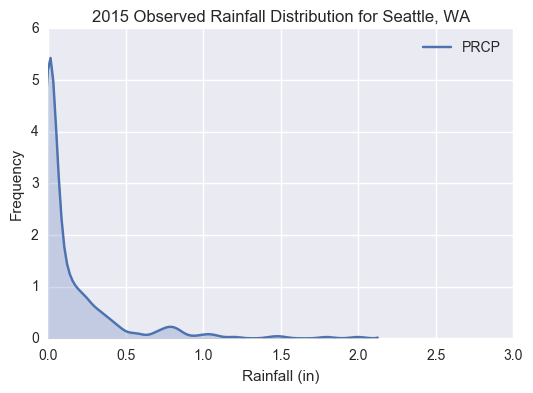

In [6]:
# This graph will show us a distribution of mean rainfall across various seattle based stations.

sns.kdeplot(rain_2015.groupby(['DATE']).PRCP.mean(), shade=True)
plt.xlim([0,3])
plt.xlabel('Rainfall (in)')
plt.ylabel('Frequency')
plt.title('2015 Observed Rainfall Distribution for Seattle, WA')

In [7]:
rain_2015['MONTH'] = pd.to_datetime(rain_2015.DATE, format = '%Y:%m:%d').dt.month

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


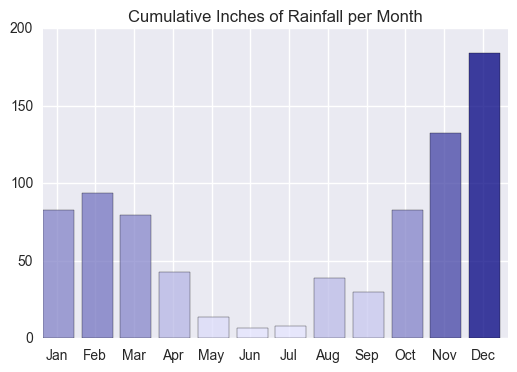

In [8]:
# Building a bar graph of the sum of rainfall in inches, with an added heatmap for effect.

month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
cmap = cm.ScalarMappable(col.Normalize(rain_2015.groupby(['MONTH']).PRCP.sum().min(),
                                       rain_2015.groupby(['MONTH']).PRCP.sum().max()), sns.light_palette('navy', as_cmap=True))

fig, ax = plt.subplots()
ax.bar(np.arange(0,12),
        rain_2015.groupby(['MONTH']).PRCP.sum(), 
       color=cmap.to_rgba(rain_2015.groupby(['MONTH']).PRCP.sum()), alpha=0.75)

plt.xticks(np.arange(0,12)+.35, month_names);
plt.title('Cumulative Inches of Rainfall per Month')

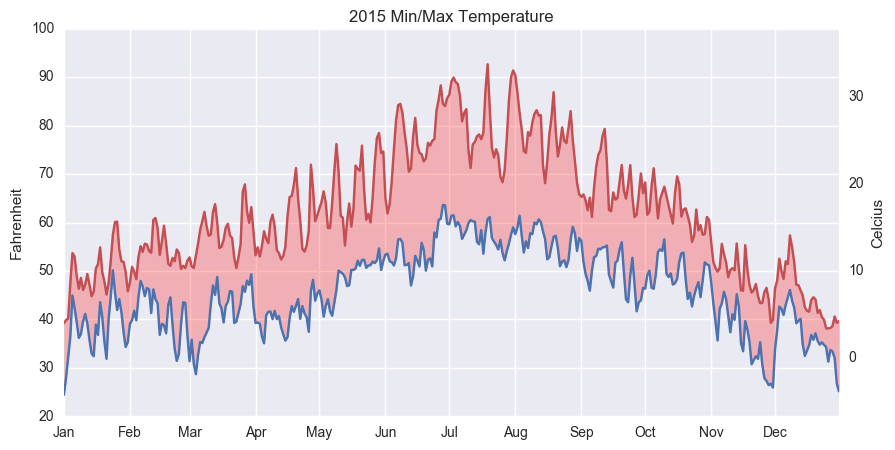

In [9]:
# Filled chart between Seattle's min and max temperatures for the year 2015
# With the left and right y axis scaled to Fahrenheit and Celcius respectively.

def fahrenheit2celsius(temp):
    return (5. / 9.) * (temp - 32)

def convert_ax_c_to_celsius(ax):
    y1, y2 = ax.get_ylim()
    ax_c.set_ylim(fahrenheit2celsius(y1), fahrenheit2celsius(y2))
    ax_c.figure.canvas.draw()

fig, ax = plt.subplots(figsize=(10,5))
ax_c = ax.twinx()

ax.callbacks.connect("ylim_changed", convert_ax_c_to_celsius)

ax.plot(rain_2015.groupby(['DATE']).TMIN.mean().index, 
        rain_2015.groupby(['DATE']).TMIN.mean())

ax.plot(rain_2015.groupby(['DATE']).TMAX.mean().index,
        rain_2015.groupby(['DATE']).TMAX.mean(), color=colors[2])

ax.fill_between(rain_2015.groupby(['DATE']).TMIN.mean().index, 
                 rain_2015.groupby(['DATE']).TMIN.mean(), 
                 rain_2015.groupby(['DATE']).TMAX.mean(),
                facecolor='red', alpha='.25')

ax_c.grid(False)

months = mdates.MonthLocator()
monthsFmt = mdates.DateFormatter('%b') 
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(monthsFmt)
ax.set_ylabel('Fahrenheit')
ax_c.set_ylabel('Celcius')
plt.title('2015 Min/Max Temperature')

In [10]:
data = []

for i in range(12):
    temps = np.append(rain_2015.groupby('MONTH').TMAX.unique().values[i],
              rain_2015.groupby('MONTH').TMIN.unique().values[i])
    data.append(temps)

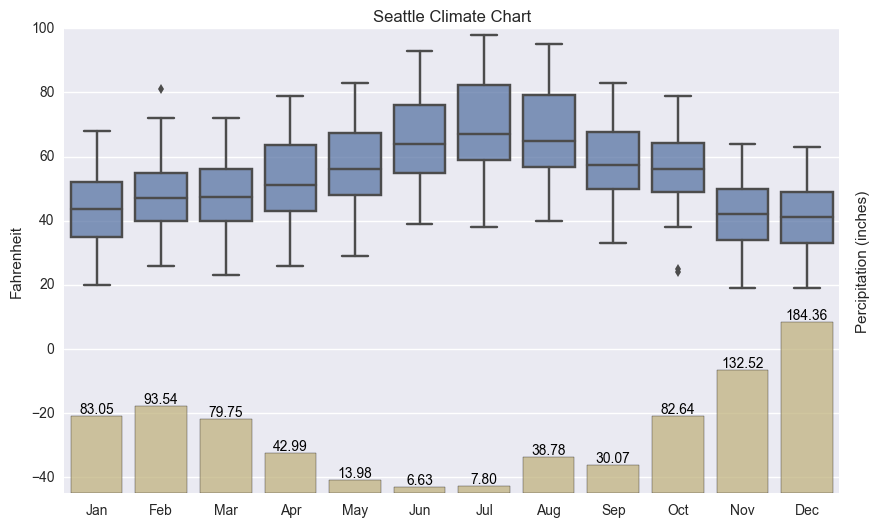

In [11]:
# This graph (similar to one you might see on Seattle's Wiki page) shows us a boxplot 
# of Seattle's min and max temperatures on one y axis, and a barplot of seattles monthly 
# rainfall sum scaled to the other.

fig, ax = plt.subplots(figsize=(10,6))
ax_p = ax.twinx()
ax_p.grid(False)

sns.boxplot(data = data, 
                 color=colors[0], ax=ax)
for patch in ax.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .75))

sns.barplot(np.arange(0,12),
        rain_2015.groupby(['MONTH']).PRCP.sum(),color=colors[4], alpha=0.75, ax=ax_p)

rect = ax_p.patches

for bar in rect:
    height = bar.get_height()
    ax_p.text(bar.get_x() + bar.get_width()/2, height+3, str("%.2f" % height), ha='center', color='k')

    
ax.set_ylabel('Fahrenheit')
ax_p.set_ylabel('Percipitation (inches)')

plt.tick_params(axis='y', left='off')
ax_p.yaxis.set_ticklabels(ticklabels=[])


plt.xticks(np.arange(0,12), month_names);
ax.set_ylim(-45,100)
ax_p.set_ylim(0,500);
plt.title('Seattle Climate Chart')



In [12]:
injuries = pd.read_csv('2015_injuries_table.csv')

In [13]:
injuries.sort_values(by='INCDTTM', inplace=True)

In [14]:
injuries = injuries[['INCDTTM','INJURIES','SERIOUSINJURIES', 'FATALITIES']]

In [15]:
injuries[['DATE', 'TIME', 'AM/PM']] = injuries.INCDTTM.str.split(expand=True)

In [16]:
injuries.head()

,INCDTTM,INJURIES,SERIOUSINJURIES,FATALITIES,DATE,TIME,AM/PM
616,1/1/2015,1,0,0,1/1/2015,None,None
933,1/1/2015,0,0,0,1/1/2015,None,None
8938,1/1/2015,0,0,0,1/1/2015,None,None
995,1/1/2015 10:25:00 AM,2,0,0,1/1/2015,10:25:00,AM
212,1/1/2015 10:34:00 PM,0,0,0,1/1/2015,10:34:00,PM


In [17]:
injuries.DATE= pd.to_datetime(injuries.DATE, format= '%m/%d/%Y')
injuries.DATE = injuries.DATE.dt.strftime('%Y-%m-%d')
injuries.TIME = pd.to_datetime(injuries.TIME, format = '%H:%M:%S').dt.time

In [18]:
injuries.drop(['INCDTTM'], axis=1, inplace=True)

In [19]:
#View some summary statistics on the INJURIES column.

injuries.groupby('DATE').INJURIES.agg({'accident_count' : 'count',
                                        'mean_injuries': 'mean', 
                                        'sum_injuries': 'sum', 
                                        'max_injuries': 'max',
                                        'std_injuries': 'std'}).head()

,accident_count,max_injuries,std_injuries,mean_injuries,sum_injuries
DATE,,,,,
2015-01-01,34,3,0.704581,0.441176,15
2015-01-02,26,2,0.549125,0.307692,8
2015-01-03,21,5,1.352247,0.857143,18
2015-01-04,22,4,0.959121,0.409091,9
2015-01-05,40,7,1.233870,0.625000,25


In [20]:
injuries['MONTH'] = pd.to_datetime(injuries.DATE, format = '%Y-%m-%d').dt.month

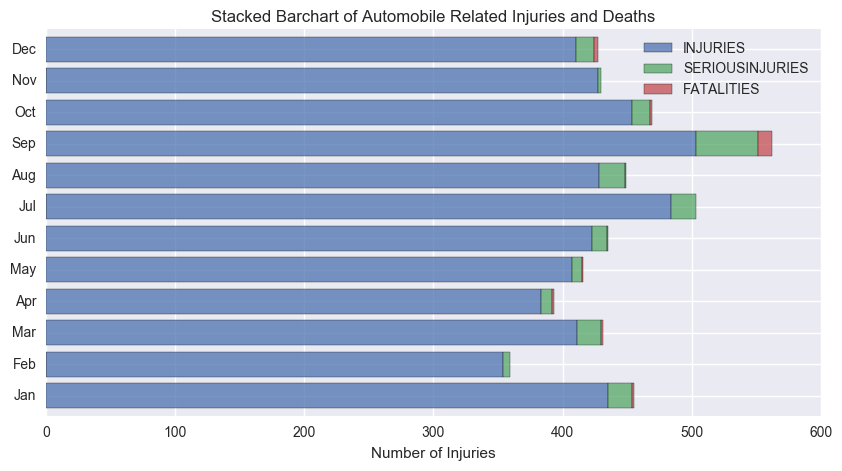

In [21]:
# This Stacked bar chart shows us the summation of all injuries and deaths due to automobile
# collisions for the year 2015. This chart allows us to quickly visualize the porportions 
# of injury types in relation to one another.

fig, ax = plt.subplots(figsize=(10,5))

injuries.groupby('MONTH')['INJURIES', 
                          'SERIOUSINJURIES', 
                          'FATALITIES'].sum().plot.barh(width=0.8,
                                                        alpha=0.75,
                                                        stacked=True, 
                                                        ax=ax)

ax.set_xlabel('Number of Injuries')
ax.set_ylabel('')
ax.grid(True)
ax.legend(loc=1)
plt.yticks(np.arange(0,12), month_names);
plt.title('Stacked Barchart of Automobile Related Injuries and Deaths')

In [22]:
injuries['DAY'] = pd.to_datetime(injuries.DATE, format = '%Y-%m-%d').dt.dayofweek

In [23]:
injuries.DAY = injuries.DAY.map({0:'Monday',1:'Tuesday',2:'Wednesday',3:'Thursday',
                  4:'Friday',5:'Saturday',6:'Sunday' })

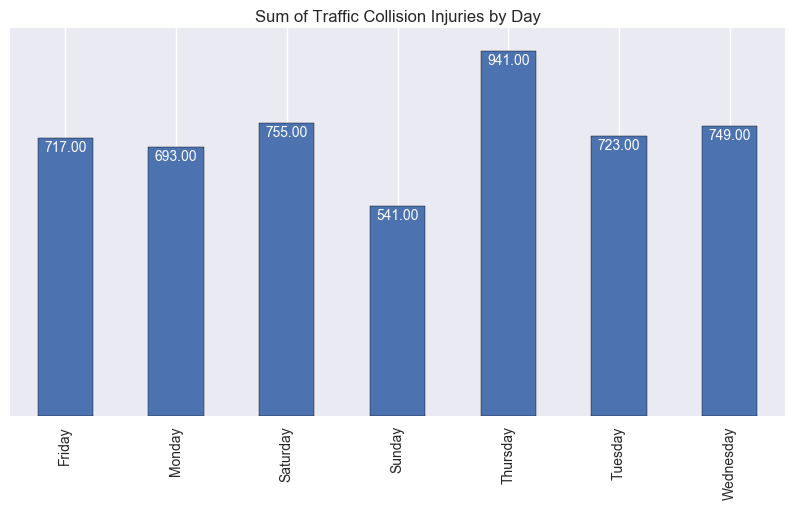

In [24]:
# Thursday seemed to be a PARTICULARLY bad day for commuting, and as one might suspect.
# And Sunday had substantially less injuries than every other day. 


fig, ax = plt.subplots(figsize=(10,5))

injuries.groupby('DAY').INJURIES.sum().plot(kind='bar', ax=ax)

rect = ax.patches

for bar in rect:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height-35, str("%.2f" % height), 
            ha='center', color='w')  
    
ax.set_title('Sum of Traffic Collision Injuries by Day')
ax.set_yticks([]);
ax.grid(True)
ax.set_xlabel('')

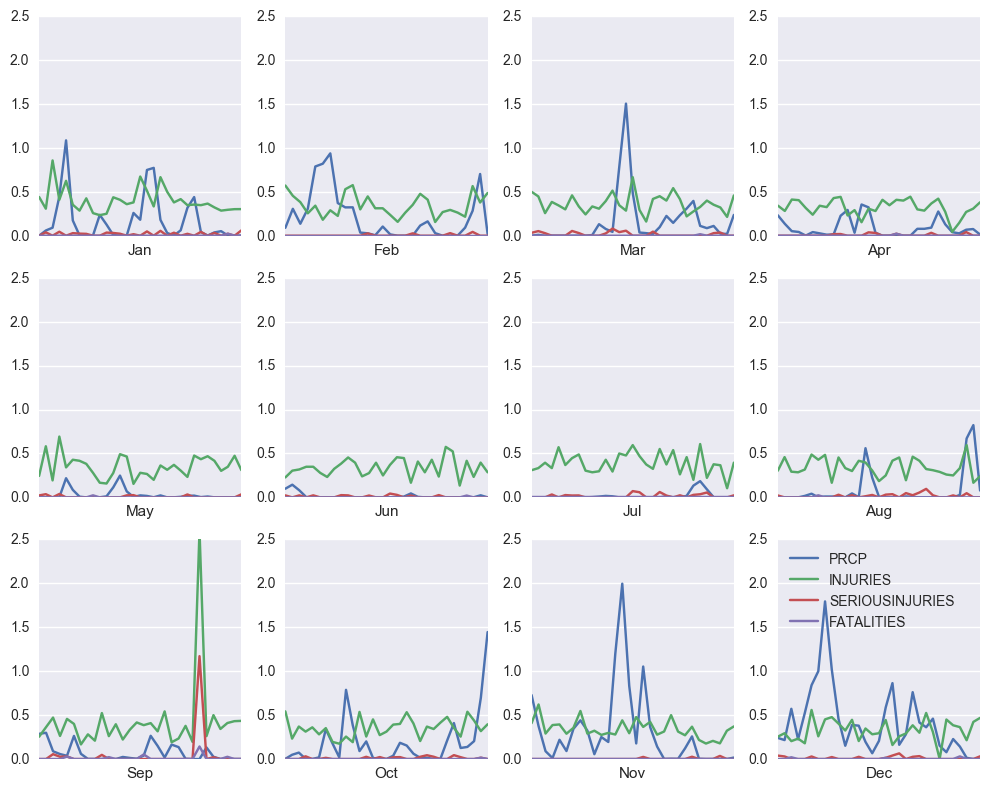

In [25]:
# These charts give us a quick visualization for how rainfall may affect collision injuries 
# and deaths. However upon a quick inspection, there doesn't seem to be much of a relationship.

fig = plt.figure(figsize=(10,8))

for i in range(12):
    
    fig.add_subplot(3,4,i+1)
    
    plt.plot_date(rain_2015.groupby(['MONTH', 'DATE']).PRCP.mean()[i+1].index,
                  rain_2015.groupby(['MONTH', 'DATE']).PRCP.mean()[i+1], '-')
    plt.plot_date(injuries.groupby(['MONTH', 'DATE']).INJURIES.mean()[i+1].index,
                 injuries.groupby(['MONTH', 'DATE']).INJURIES.mean()[i+1], '-')
    plt.plot_date(injuries.groupby(['MONTH', 'DATE']).SERIOUSINJURIES.mean()[i+1].index,
                 injuries.groupby(['MONTH', 'DATE']).SERIOUSINJURIES.mean()[i+1], '-')
    plt.plot_date(injuries.groupby(['MONTH', 'DATE']).FATALITIES.mean()[i+1].index,
                 injuries.groupby(['MONTH', 'DATE']).FATALITIES.mean()[i+1], '-')
    
    plt.ylim(0,2.5)
    plt.xlabel(month_names[i])
    plt.xticks([])
    
    
plt.legend(loc=2)
plt.tight_layout()

    